###CNN

**Multilayer cnn**

As an example, first conv layer looking for lines and edges on image and second conv layer made filters from data from previous conv layer



```python
tf.keras.layers.Conv2D(<number_of_filters>)
```



**Pooling**

types: max, min, average

Pooling layer reduce the dimensionality of the previous feature map. Pooling layer makes feature map smaller.

pool_size is the size of the filter.

Padding in Conv2D layer allows us to ensure that feature map has the same size as the input

**CNN has VGG style architecture**

In [59]:
!pip install visualkeras

In [113]:
import cv2
import visualkeras
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [90]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')

In [91]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [92]:
x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [93]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 10))

Dropout layer simply randomly drop nodes out of the network



```python
Dropout(0.2)
```
0.2 = 20%. Retain 80% of nodes


###Distributed strategy configuration

In [94]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"],
                                          cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

clear_output()

In [95]:
print(f'Number of devices: {strategy.num_replicas_in_sync}')

Number of devices: 2


In [96]:
input_shape = (32, 32, 3)
padding = 'same'
activation = 'relu'
batch_size = 64

In [97]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=batch_size)

steps = int(x_train.shape[0] / 64)

**The BatchNormalization layer can be added to your model to standardize raw input variables or the outputs of a hidden layer**

**Bias in ML does help us generalize better and make our model less sensitive to some single data point**

In [69]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [70]:
def define_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding=padding, data_format='channels_last', input_shape=input_shape, kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding=padding, activation=activation, kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(64, (3, 3), padding=padding, activation=activation, kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding=padding, activation=activation, kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(128, (3, 3), padding=padding, activation=activation, kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding=padding, activation=activation, kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.SGD(0.01, momentum=0.9, nesterov=True)

    model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    return model

In [71]:
def fit_model(model):
    callbacks = [
        tf.keras.callbacks.LearningRateScheduler(scheduler)
    ]

    h = model.fit(it_train, steps_per_epoch=steps, epochs=25, validation_data=(x_test, y_test), batch_size=batch_size, callbacks=[callbacks])

    return h

In [ ]:
with strategy.scope():
    model = define_model()
    h = fit_model(model)

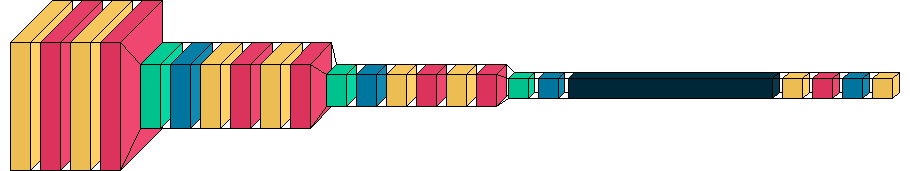

In [98]:
visualkeras.layered_view(model)

The output shape of first layer less than input shape. It happens because we do the sampling (3, 3).

In [74]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_21 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_22 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 64)       

###Visualization

In [75]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.4963 - accuracy: 0.8290


[0.49630019068717957, 0.8289999961853027]

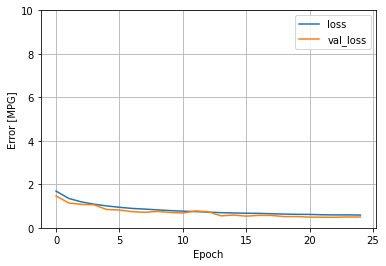

In [76]:
plot_loss(h)

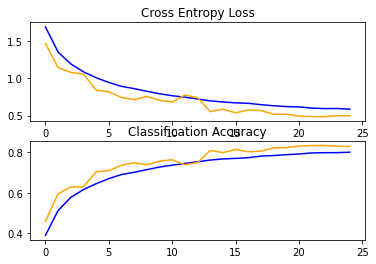

In [77]:
summarize_diagnostics(h)

In [79]:
path = 'drive/MyDrive/Colab Notebooks/code_camp/1/cifar10.h5'
model.save(path)